## Imports

In [0]:
import numpy as np
import keras
import matplotlib.pyplot as plt
import keras.utils as np_utils
# Import optimizer
from keras.optimizers import SGD
# Import data
from keras.datasets import cifar100
# Import models and layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Activation
# Import image proprocessors
from keras.preprocessing.image import ImageDataGenerator
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

## Auxiliar functions

Configures the model.
Args:
+ ```optimizer:``` Optimizer function.
+ ```loss:``` Loss function.
+ ```metrics:``` Metric function.

In [0]:
def compile(model, loss, optimizer, metrics):
    model.compile(loss = loss,
                  optimizer = optimizer,
                  metrics = metrics)

Trains the given model.

args:
+ ```model:``` Model to train.
+ ```batch_size:``` Hyperparameter of gradient descent that controls the number of training samples to work through before the model’s internal parameters are updated.
+ ```epochs:``` Hyperparameter of gradient descent that controls the number of complete passes through the training dataset.
+ ```data:``` Given by ```x_train```, ```x_test```, ```y_train``` and ```y_test```

In [0]:
def train(model, batch_size, epochs, x_train, y_train, x_test, y_test):
    history = model.fit(x_train, y_train,
          batch_size = batch_size,
          epochs = epochs,
          verbose = 0,
          validation_data = (x_test, y_test))
    return history

Shows model results in test partition.

In [0]:
def results(model, x_test, y_test):
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss: ', score[0])
    print('Test accuracy: ', score[1])

Calculates model accuracy.

In [0]:
def calAccuracy(labels, preds):
    labels = np.argmax(labels, axis = 1)
    preds = np.argmas(preds, axis = 1)
    
    return sum(labels==preds)/len(labels)

Draws two graphics.
+ Loss function evolution.
+ Accuracy function evolution.

Args:
+ ```hist```: Training records

In [0]:
def showEvolution(hist):
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training loss', 'Validation loss'])
    plt.show()
    
    acc = hist.history['acc']
    val_acc = hist.history['val_acc']
    plt.plot(acc)
    plt.plot(val_acc)
    plt.legend(['Training accuracy', 'Validation accuracy'])
    plt.show()

In [0]:
def show_evolution_val(*hist):
    """Pinta dos gráficas: una con la evolución de la función de pérdida en el conjunto
       de validación para todos los modelos, y otra con la evolución del accuracy
       en el conjunto de validación para todos los modelos.
        - *hist: lista de historiales de entrenamientos de los modelos."""

    # Evolución de las funciones de pérdida
    for h in hist:
        val_loss = h.history['val_loss']
        plt.plot(val_loss)

    plt.legend(["Validation loss " + str(i + 1) for i in range(len(hist))])
    plt.show()

    # Evolución del accuracy
    for h in hist:
        val_acc = h.history['val_acc']
        plt.plot(val_acc)

    plt.legend(["Validation accuracy " + str(i + 1) for i in range(len(hist))])

    plt.show()

# Exercise 1

## Load Data.

In [0]:
def loadCifarData():
    # Load Data
    (x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

    # Transform to float and normalize
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255
    
    # We will use only 25 classes.
    train_idx = np.isin(y_train, np.arange(25))
    train_idx = np.reshape(train_idx, -1)
    x_train = x_train[train_idx]
    y_train = y_train[train_idx]
    test_idx = np.isin(y_test, np.arange(25))
    test_idx = np.reshape(test_idx, -1)
    x_test = x_test[test_idx]
    y_test = y_test[test_idx]
    
    # Pass variables to cathegorical
    y_train = np_utils.to_categorical(y_train, 25)
    y_test = np_utils.to_categorical(y_test, 25)
    
    return x_train, y_train, x_test, y_test

In [0]:
def dataGenerator1():
    datagen = ImageDataGenerator(featurewise_center = True, 
                                 featurewise_std_normalization = True,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True,
                                 validation_split = 0.1,
                                 )
    return datagen

In [0]:
def dataGenerator2():

  datagen = ImageDataGenerator(featurewise_center= True,  # set input mean to 0 over the dataset
        samplewise_center = False,  # set each sample mean to 0
        featurewise_std_normalization = True,  # divide inputs by std of the dataset
        samplewise_std_normalization = False,  # divide each input by its std
        zca_whitening = False,  # apply ZCA whitening
        zca_epsilon = 1e-06,  # epsilon for ZCA whitening
        rotation_range = 0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range = 0.,  # set range for random shear
        zoom_range = 0.,  # set range for random zoom
        channel_shift_range = 0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode = 'nearest',
        cval = 0.,  # value used for fill_mode = "constant"
        horizontal_flip = True,  # randomly flip images
        vertical_flip = False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale = None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split = 0.1)
  return datagen

## Model Definition

In [0]:
def baseNetModel():
    model = Sequential()
    model.name = 'BaseNet Model'
    model.add(Conv2D(6, kernel_size=(5, 5),
                     activation='relu',
                     input_shape=(32,32,3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(16, kernel_size=(5,5), 
                    activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(25, activation='softmax'))
    
    return model

In [0]:
def baseNetModel2():
    model = Sequential()
    model.name = 'BaseNet Model 2'
    model.add(Conv2D(32, (3, 3), padding='same', activation = 'relu', input_shape=(32,32,3)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(25, activation='softmax'))

    return model

## Model train and test

In [0]:
def ej1(modelFunction, batch_size, epochs):
    model = modelFunction()
    model.summary()
    compile(model,
        keras.losses.categorical_crossentropy,
        SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True),
        ['accuracy'])
    
    data = loadCifarData()
    # data = x_train, y_train, x_test, y_test
    
    history = train(model, 
                    batch_size,
                    epochs,
                    *data,
                    )
    print("# TEST RESULTS")
    results(model, *data[2:])
    showEvolution(history)
    return history

In [0]:
def ej2(modelFunction, dataGenfunction, batch_size, epochs):
    model = modelFunction()
    model.summary()
    compile(model,
            keras.losses.categorical_crossentropy,
            SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True),
            ['accuracy'])
    x_train, y_train, x_test, y_test = loadCifarData()

    datagen = dataGenfunction()
    datagen.fit(x_train)
    datagen.standardize(x_test)

    history = model.fit_generator(
                                  datagen.flow(x_train, y_train, batch_size, subset='training'),
                                  steps_per_epoch = len(x_train)*0.9/batch_size,
                                  epochs = epochs,
                                  validation_data = datagen.flow(x_train, y_train, batch_size, subset='validation'),
                                  validation_steps = len(x_train)*0.1/batch_size,
                                  verbose=0
                                  )

    print("# TEST RESULTS")
    results(model, x_test, y_test)
    showEvolution(history)
    return history

# Main function

Model: "BaseNet Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_119 (Conv2D)          (None, 28, 28, 6)         456       
_________________________________________________________________
max_pooling2d_75 (MaxPooling (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_120 (Conv2D)          (None, 10, 10, 16)        2416      
_________________________________________________________________
max_pooling2d_76 (MaxPooling (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_38 (Flatten)         (None, 400)               0         
_________________________________________________________________
dense_75 (Dense)             (None, 50)                20050     
_________________________________________________________________
dense_76 (Dense)             (None, 25)              

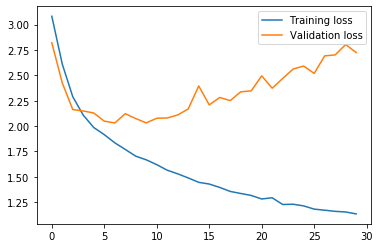

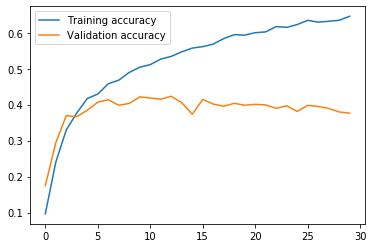

Model: "BaseNet Model 2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_121 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_122 (Conv2D)          (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_77 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_67 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_123 (Conv2D)          (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_124 (Conv2D)          (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_78 (MaxPooling (None, 6, 6, 64)      

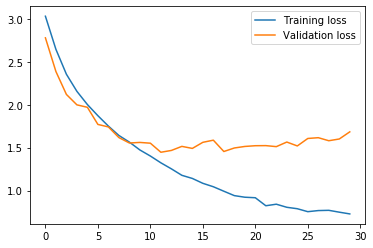

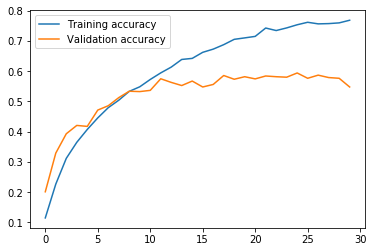

Model: "BaseNet Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_125 (Conv2D)          (None, 28, 28, 6)         456       
_________________________________________________________________
max_pooling2d_79 (MaxPooling (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_126 (Conv2D)          (None, 10, 10, 16)        2416      
_________________________________________________________________
max_pooling2d_80 (MaxPooling (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_40 (Flatten)         (None, 400)               0         
_________________________________________________________________
dense_79 (Dense)             (None, 50)                20050     
_________________________________________________________________
dense_80 (Dense)             (None, 25)              

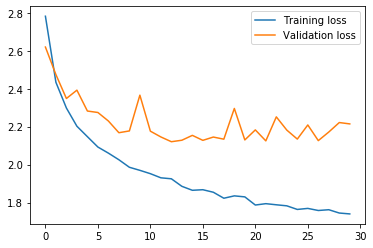

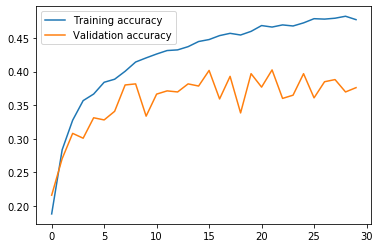

Model: "BaseNet Model 2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_127 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_128 (Conv2D)          (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_81 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_70 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_129 (Conv2D)          (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_130 (Conv2D)          (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_82 (MaxPooling (None, 6, 6, 64)      

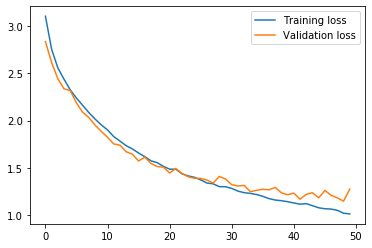

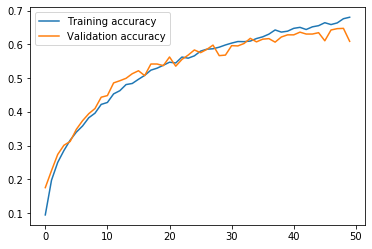

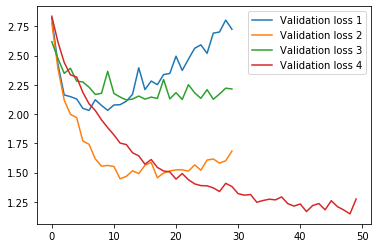

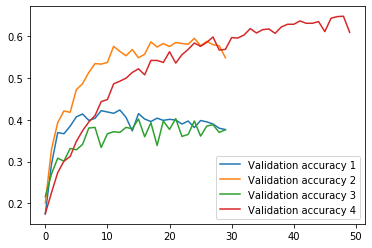

In [258]:
def main():
    h = []
    h.append(ej1(baseNetModel, 32, 30))
    h.append(ej1(baseNetModel2, 32, 30))
    h.append(ej2(baseNetModel, dataGenerator1, 32, 30))
    h.append(ej2(baseNetModel2, dataGenerator2, 128, 50))
    
    show_evolution_val(*h)
main()